# DSI Team Starting Point

### Background

DSI Phase I:
- Cleaned and Analyzed Historical CFPB Agreement Data looking to understand offered APRs
    - Team found initial analysis lacking in meaning due to the nature of the APR values reported in the agreements
        - The Reported APRs were listed as a "middle point" across customer segments per plan per agreement.
        - This ultiamtely meant that the APR value was already a range or a value from a range rather than the discreet values themselves.
    - Later found out from data stewards that the historical data is non-verifiable, meaning the reported APRs were hard to relate to the actual offerings at that time.
    - Data Teams Presentations:
        - <a href="https://github.com/chrisJoyceDS/top_sprint_data/blob/main/code/CFPB_Data.ipynb"> Jupyter Notebook Repo </a>
        - <a href="https://docs.google.com/presentation/d/16vBsI7b5Fw_0tF1UQK4qW2dn32v66PwcC3VZ959mx4c/edit#slide=id.p"> Presentation to the Team </a>
        - <a href="https://docs.google.com/presentation/d/18uy5qkw0zQTg-SA-ceXDKOI2dCI4RLN-IjSQXfIwCIM/edit#slide=id.p"> Presentation to the CFPB </a>

DSI Phase II:
- After having it confirmed that the historical data was innacurate and far from reality, the team learned of and used the updated dataset provided by the CFPB
- This data was from July 2022 to December 2022 and had a variety of updated information with respect to the historical data
- Unfortunately there is no data dictionary for this dataset, and we will have to interpet their values based on the column descriptions
- for the sake of the team, we left most of the column names intact, and update a few where we thought it was best/relevant
- Please follow us along or Select "Jump to Clustering" below:

[Jump to Clustering](#Clustering)

In [138]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import cm
import seaborn as sns
import re
import missingno as msno

# imputing
from sklearn.impute import KNNImputer
# preprocessing
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.compose import make_column_transformer
#clustering
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA

- The dataset data doesn't fall on the usual A0 cell, we needed to adjust the pandas reader

In [139]:
columns_to_read = 'B:FO'

In [140]:
df = pd.read_excel("../data/cfpb_updated_tccp.xlsx",skiprows=9,usecols=columns_to_read)

In [141]:
df.head()

,Institution Name,Product Name,Report Date,Availability of Credit Card Plan,State,State (Multiple),Pertains to Specific Counties?,Requirements for Opening,Requirements for Opening Types,Geographic Restrictions,...,Services,Other Services,Rewards,Other Rewards,Card Features,Other Card Features,Contact Information Types,Website for Consumer,Telephone Number for Consumers,Created Date
0,FNBT BANK,MasterCard,Data as of December 31,National,NaN,NaN,NaN,No,NaN,NaN,...,NaN,NaN,Cashback rewards,NaN,Chip card,NaN,Phone; Website,https:www.fnbt.com,1-800-899-4321,3/21/2023
1,WINTHROP AREA FEDERAL CREDIT UNION,Visa Credit Platinum,Data as of December 31,National,NaN,NaN,NaN,No,NaN,NaN,...,NaN,NaN,Cashback rewards; Travel-related rewards,NaN,Contactless Payments; Chip card; Fee-free fore...,NaN,Phone; Website,https://www.winthropcreditunion.org,800-511-1120,3/21/2023
2,WOORI AMERICA BANK,Classic,Data as of December 31,National,NaN,NaN,NaN,Yes,NaN,NaN,...,Automobile rental insurance; Credit card regis...,NaN,Travel-related rewards,NaN,Chip card; Fee-free foreign transactions; Mobi...,NaN,Website,https://www.wooriamericabank.com,NaN,3/21/2023
3,CENTRAL BANK & TRUST COMPANY,Classic Visa,Data as of December 31,Regional,NaN,IN; KY; OH,No,Yes,NaN,NaN,...,Automobile rental insurance; Other,Roadside assistance,NaN,NaN,Contactless Payments; Chip card; Mobile wallet...,NaN,Phone; Website,https://www.centralbank.com,(800)637-6884,3/22/2023
4,CLEARWATER FEDERAL CREDIT UNION,Visa,Data as of December 31,National,NaN,NaN,NaN,No,Other. Please Describe:,NaN,...,Debt cancellation coverage; Other,Visa's credit monitoring (Norton Lifelock cred...,NaN,NaN,Contactless Payments; Chip card; Mobile wallet...,NaN,Phone; Website,https://www.clearwatercreditunion.org,800-254-1803,3/22/2023


In [142]:
df.shape

(648, 170)

- Key differences between this data set and the historical data set
    - This is not timeseries, it is each institution's plan data as of December 31 of the participants in the survey
    - Phase I dataset was (rows:9556,columns:12)
    - more dense of a dataset
- let's check out the null landscape below

<Axes: >

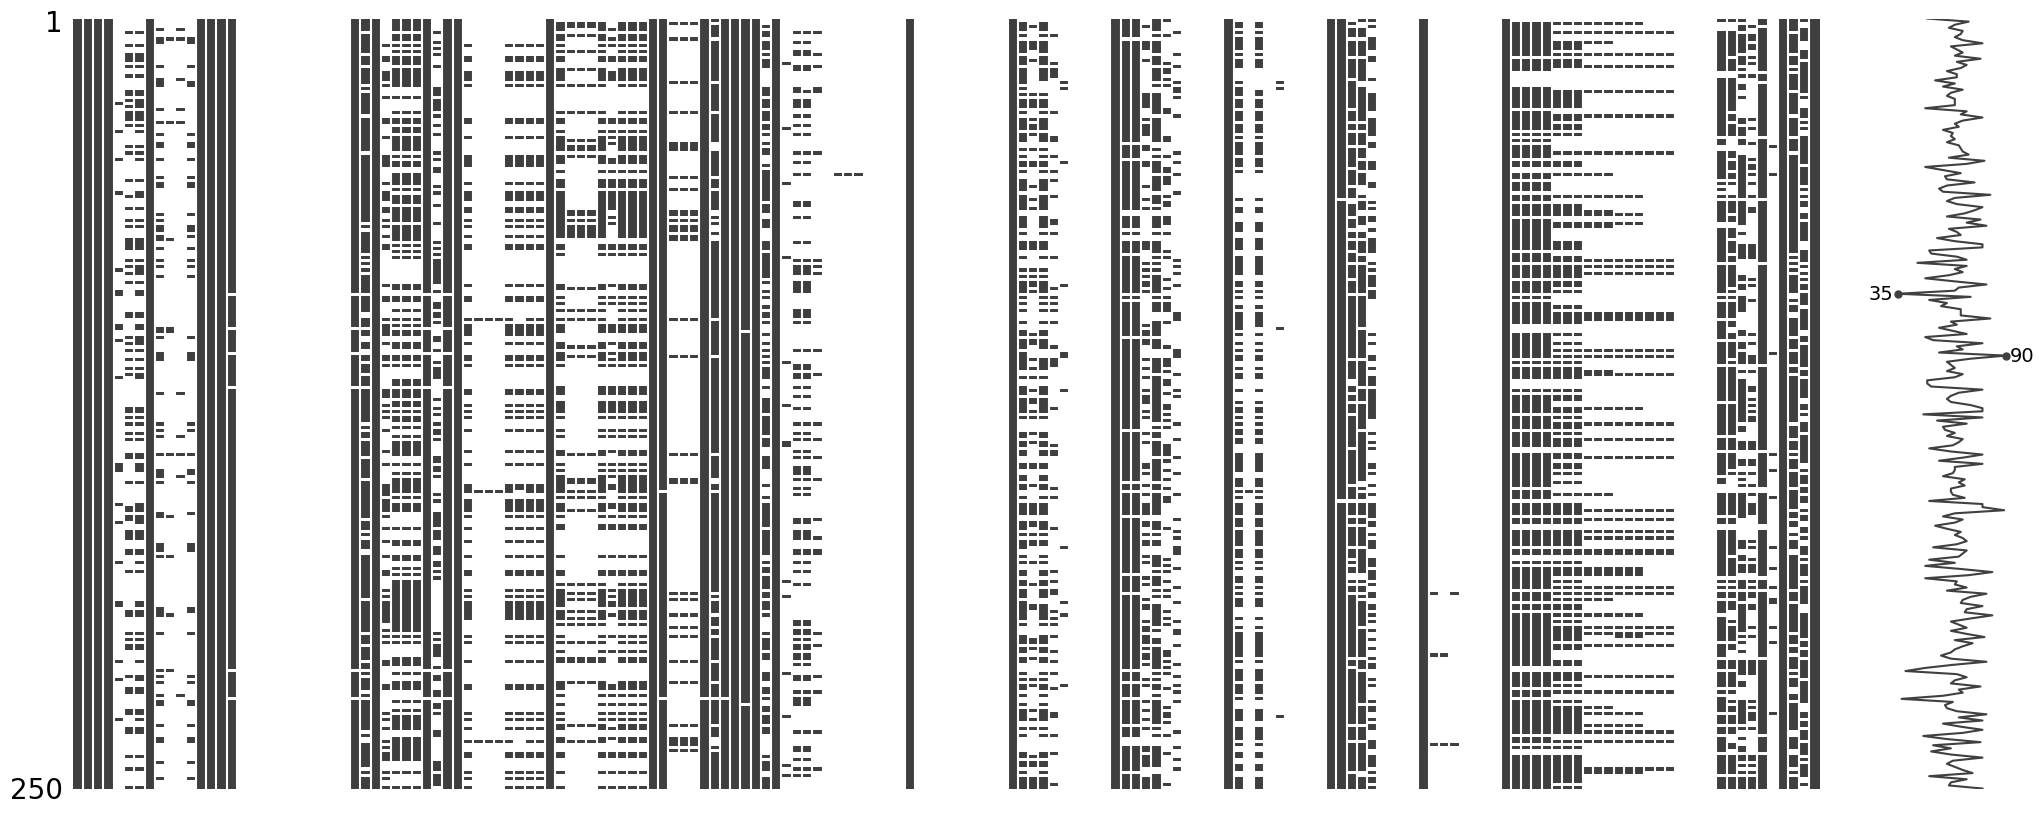

In [143]:
msno.matrix(df.sample(250))

- What you are seeing is a graphical representation of the data within the new data set:
    - Black means data
    - White means no data
- With more fields collected, comes the even possibility of not collecting it.
- Below is the start of our initial clean process. Because of the look of the dataset above, and the sheer amount of initial features we have (170) we are going to make some swift cuts

In [144]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 648 entries, 0 to 647
Columns: 170 entries, Institution Name to Created Date
dtypes: float64(97), object(73)
memory usage: 860.8+ KB


In [145]:
# Calculate the percentage of null values in each column
null_percentage = (df.isnull().sum() / len(df)) * 100

In [146]:
type(null_percentage)

pandas.core.series.Series

In [147]:
null_percentage.shape

(170,)

In [148]:
# set threshold
threshold = 90

In [149]:
# Create a list of column names to drop where the null percentage is greater than or equal to the threshold
columns_to_drop = null_percentage[null_percentage >= threshold].index.tolist()

In [150]:
len(columns_to_drop)

68

In [151]:
# drop the columns
df.drop(columns=columns_to_drop,inplace=True)

In [152]:
df.shape

(648, 102)

- Above we:
    - Calculated the null percentage for each column of the 170
    - set a threshold of 90 percent null as the cut off
    - removed all columns that met that threshould and above
    - resulting in dropping 68 columns
- You can see the impact below, and it's much better, but we still have 102 features, which means we will be greedier in our selection

<Axes: >

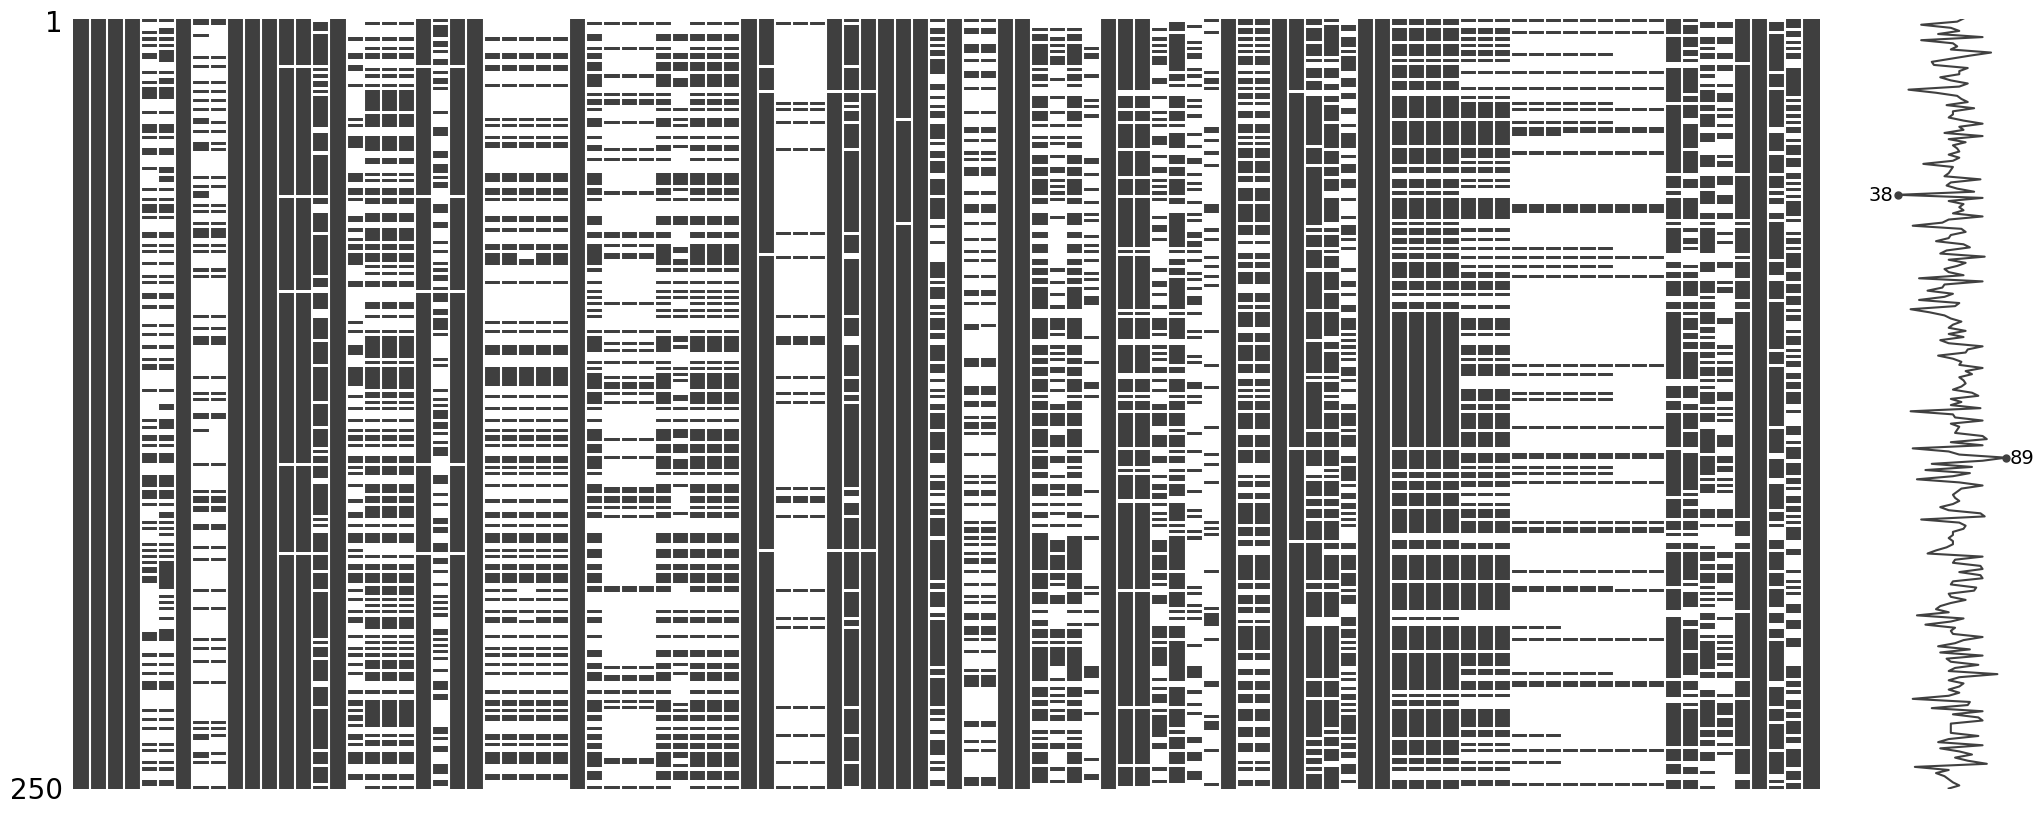

In [153]:
msno.matrix(df.sample(250))

In [154]:
df.head()

,Institution Name,Product Name,Report Date,Availability of Credit Card Plan,State (Multiple),Pertains to Specific Counties?,Requirements for Opening,Requirements for Opening Types,Other,Secured Card,...,Other Fee Explanation.4,Services,Other Services,Rewards,Other Rewards,Card Features,Contact Information Types,Website for Consumer,Telephone Number for Consumers,Created Date
0,FNBT BANK,MasterCard,Data as of December 31,National,NaN,NaN,No,NaN,NaN,No,...,NaN,NaN,NaN,Cashback rewards,NaN,Chip card,Phone; Website,https:www.fnbt.com,1-800-899-4321,3/21/2023
1,WINTHROP AREA FEDERAL CREDIT UNION,Visa Credit Platinum,Data as of December 31,National,NaN,NaN,No,NaN,NaN,No,...,NaN,NaN,NaN,Cashback rewards; Travel-related rewards,NaN,Contactless Payments; Chip card; Fee-free fore...,Phone; Website,https://www.winthropcreditunion.org,800-511-1120,3/21/2023
2,WOORI AMERICA BANK,Classic,Data as of December 31,National,NaN,NaN,Yes,NaN,NaN,No,...,NaN,Automobile rental insurance; Credit card regis...,NaN,Travel-related rewards,NaN,Chip card; Fee-free foreign transactions; Mobi...,Website,https://www.wooriamericabank.com,NaN,3/21/2023
3,CENTRAL BANK & TRUST COMPANY,Classic Visa,Data as of December 31,Regional,IN; KY; OH,No,Yes,NaN,NaN,No,...,NaN,Automobile rental insurance; Other,Roadside assistance,NaN,NaN,Contactless Payments; Chip card; Mobile wallet...,Phone; Website,https://www.centralbank.com,(800)637-6884,3/22/2023
4,CLEARWATER FEDERAL CREDIT UNION,Visa,Data as of December 31,National,NaN,NaN,No,Other. Please Describe:,Person must qualify for membership based on th...,No,...,NaN,Debt cancellation coverage; Other,Visa's credit monitoring (Norton Lifelock cred...,NaN,NaN,Contactless Payments; Chip card; Mobile wallet...,Phone; Website,https://www.clearwatercreditunion.org,800-254-1803,3/22/2023


In [155]:
# get remaining column data types
col_types = df.dtypes

In [156]:
# separate out numerical and object columns
num_cols = col_types[col_types != 'object'].index.tolist()
obj_cols = col_types[col_types == 'object'].index.tolist()

In [157]:
df[num_cols].shape

(648, 40)

In [158]:
df[obj_cols].shape

(648, 62)

In [159]:
df[num_cols].isnull().sum().sum(), df[obj_cols].isnull().sum().sum()

(13313, 11087)

In [160]:
# re-Calculate the percentage of null values in each column
null_percentage = (df.isnull().sum() / len(df)) * 100

In [161]:
null_percentage.sort_values(ascending=False)[null_percentage >= 59]

Good Credit.3                           89.197531
Great Credit.3                          89.197531
Poor or Fair Credit.3                   89.197531
Other Fee Explanation.4                 88.425926
Other Fee Name.4                        88.425926
Other Fee Amount.4                      88.425926
Other Fee Name.3                        83.796296
Poor or Fair Credit.2                   83.796296
Other Fee Amount.3                      83.796296
Other Fee Explanation.3                 83.796296
Good Credit.2                           83.796296
Great Credit.2                          83.796296
Cash Advance Fee Calculation            81.481481
Other Fee Amount.2                      81.481481
Other Fee Explanation.2                 81.481481
Other Fee Name.2                        81.481481
Other                                   80.555556
Minimum Balance Transfer Fee Amount     80.401235
Requirements for Opening Types          75.000000
Minimum Cash Advance Fee Amount         68.827160


In [162]:
# additional columns to drop
cols_to_drop = null_percentage[null_percentage >= 60].index.tolist()

In [163]:
len(cols_to_drop)

34

In [164]:
# drop additional columns
# drop the columns
df.drop(columns=cols_to_drop,inplace=True)

In [165]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 648 entries, 0 to 647
Data columns (total 68 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Institution Name                          648 non-null    object 
 1   Product Name                              648 non-null    object 
 2   Report Date                               648 non-null    object 
 3   Availability of Credit Card Plan          648 non-null    object 
 4   Requirements for Opening                  648 non-null    object 
 5   Secured Card                              648 non-null    object 
 6   Targeted Credit Tiers                     648 non-null    object 
 7   Purchase APR Offered?                     648 non-null    object 
 8   Purchase APR Vary by Balance              634 non-null    object 
 9   Purchase APR Index                        634 non-null    object 
 10  Variable Rate Index                   

- Same exercise, new threshold, this time anything that was greater or equal to 59% null
- Now we have 68 Columns (5.5 times the features we had with historical btw) with a much better look of data below

<Axes: >

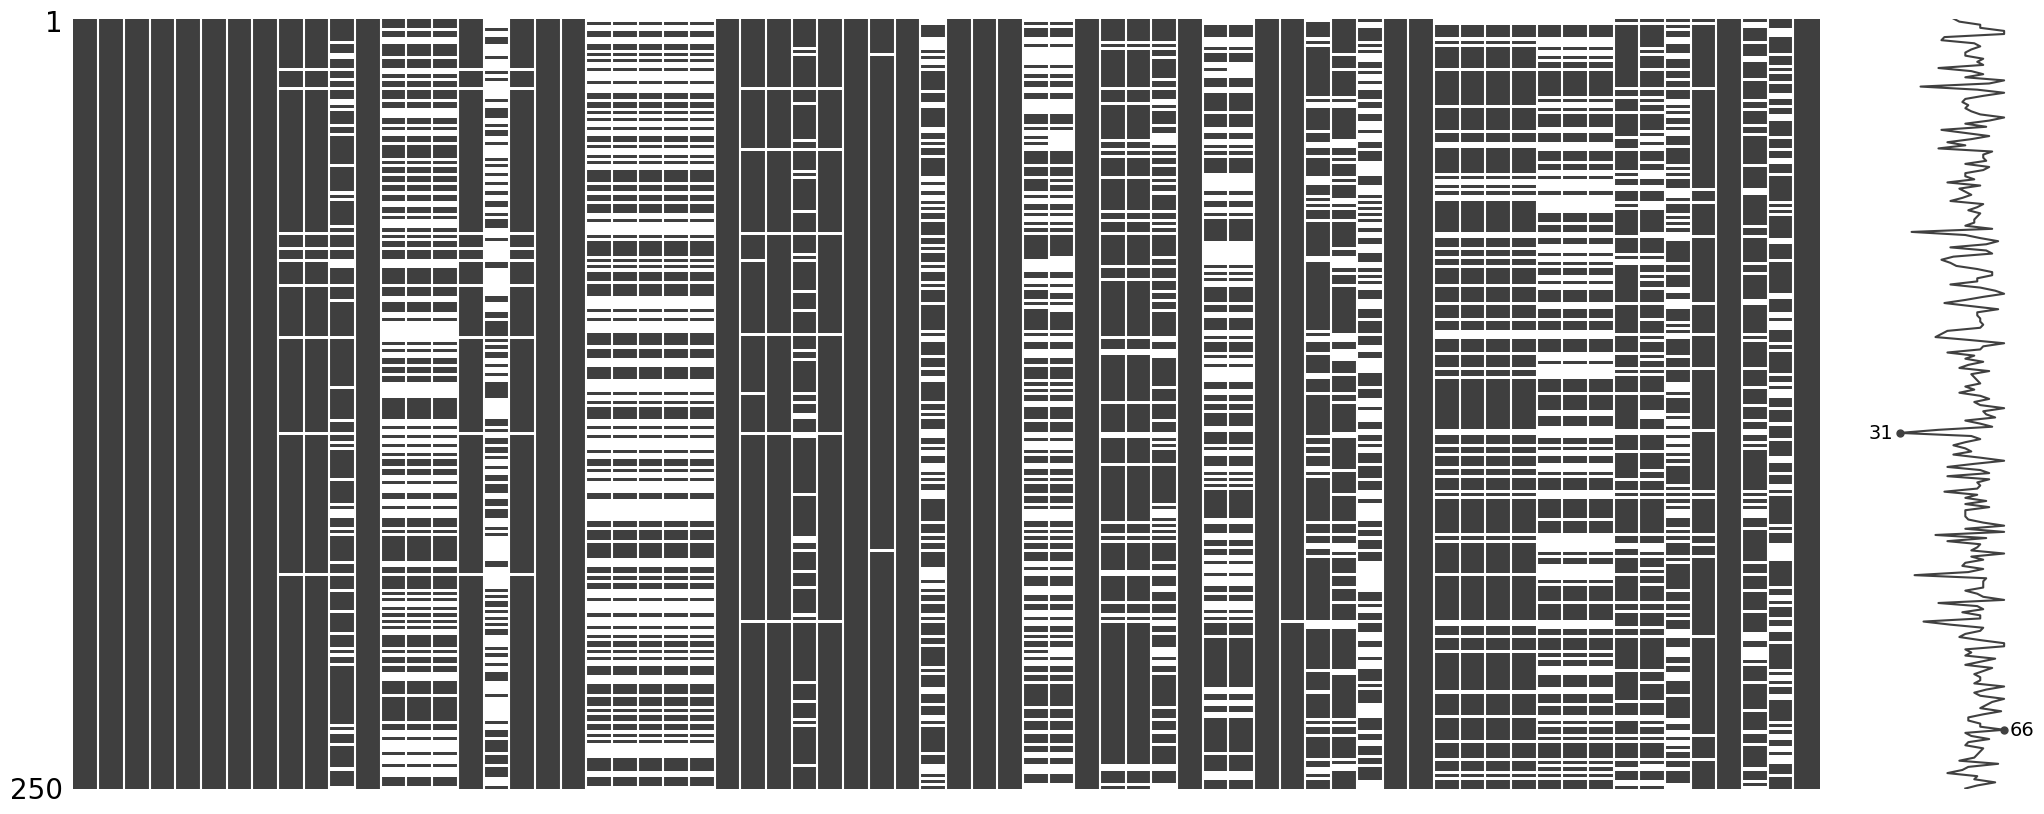

In [166]:
msno.matrix(df.sample(250))

In [167]:
df.columns.shape

(68,)

- Something you will have noticed, if you read our initial analysis, is that there are less visualizations for this data set
- There will be more going forward, but for now we have prioritized creating aggregate cards for the Software Engineering Team to be able to start building
- From this point we will be doing a mix of cleaning, feature engineering, preprocessing, and clustering

---
## MVP Goal

- Create Aggregate cards based on the targeted credit tiers 
- Capture APR, Grace Periods, Late Fees, Rewards, and Annual Fees

In [168]:
df["Targeted Credit Tiers"] = df["Targeted Credit Tiers"].apply(lambda x: x.lower())

In [169]:
df["Targeted Credit Tiers"].value_counts()

Targeted Credit Tiers
poor or fair credit (credit score 619 or less); good credit (credit scores from 620 to 719); great credit (credit score of 720 or greater)    275
good credit (credit scores from 620 to 719); great credit (credit score of 720 or greater)                                                    164
great credit (credit score of 720 or greater)                                                                                                  89
poor or fair credit (credit score 619 or less)                                                                                                 80
good credit (credit scores from 620 to 719)                                                                                                    34
poor or fair credit (credit score 619 or less); good credit (credit scores from 620 to 719)                                                     6
Name: count, dtype: int64

- split the strings on the ';'
- for the non technical this just makes it easier for us to interact with
- Goes from:
    - good credit (credit scores from 620 to 719); great credit (credit score of 720 or greater) 
    - to
    - ['good credit (credit scores from 620 to 719)',
 'great credit (credit score of 720 or greater)']

In [170]:
df["Targeted Credit Tiers"] = df["Targeted Credit Tiers"].str.split("; ")

- Create three columns that align with the credit score group.
- if the word is found in a given list of options for a specific group, report True, else False 

In [171]:
# Create Separate Columns for each bucket
df['Poor_Fair_Group'] = df['Targeted Credit Tiers'].apply(lambda x: any(re.search(r'poor', s) for s in x))
df['Good_Credit_Group'] = df['Targeted Credit Tiers'].apply(lambda x: any(re.search(r'good', s) for s in x))
df['Great_Credit_Group'] = df['Targeted Credit Tiers'].apply(lambda x: any(re.search(r'great', s) for s in x))

In [172]:
df[['Poor_Fair_Group','Good_Credit_Group','Great_Credit_Group']]

,Poor_Fair_Group,Good_Credit_Group,Great_Credit_Group
0,False,True,False
1,False,True,True
2,False,True,True
3,True,True,True
4,True,True,True
...,...,...,...
643,False,False,True
644,False,False,True
645,False,False,True
646,True,True,True


In [173]:
# remove original column
df.drop("Targeted Credit Tiers", axis=1, inplace=True)

In [174]:
# convert boolean into numerical values
df['Poor_Fair_Group'] = df['Poor_Fair_Group'].astype(int)
df['Good_Credit_Group'] = df['Good_Credit_Group'].astype(int)
df['Great_Credit_Group'] = df['Great_Credit_Group'].astype(int)

In [175]:
df[['Poor_Fair_Group','Good_Credit_Group','Great_Credit_Group']].head()

,Poor_Fair_Group,Good_Credit_Group,Great_Credit_Group
0,0,1,0
1,0,1,1
2,0,1,1
3,1,1,1
4,1,1,1


In [176]:
df.columns

Index(['Institution Name', 'Product Name', 'Report Date',
       'Availability of Credit Card Plan', 'Requirements for Opening',
       'Secured Card', 'Purchase APR Offered?', 'Purchase APR Vary by Balance',
       'Purchase APR Index', 'Variable Rate Index', 'Index',
       'Poor or Fair Credit', 'Good Credit', 'Great Credit', 'Minimum APR',
       'Median APR', 'Maximum APR', 'Introductory APR Offered?',
       'Balance Transfer Offered?', 'Balance Transfer APR Vary by Credit Tier',
       'Minimum APR.2', 'Maximum APR.2',
       'Median Length of Balance Transfer APR',
       'Balance Transfer Grace Period', 'Cash Advance APR Offered?',
       'Cash Advance APR Vary by Credit Tier', 'Minimum APR.3', 'Median APR.3',
       'Maximum APR.3', 'Grace Period Offered?', 'Grace Period',
       'Minimum Finance Charge?', 'Minimum Finance Charge (Dollars)',
       'Balance Computation Method', 'Purchase Transaction Fees',
       'Balance Transfer Fees?', 'Balance Transfer Fee Types',
       

In [177]:
df.head()

,Institution Name,Product Name,Report Date,Availability of Credit Card Plan,Requirements for Opening,Secured Card,Purchase APR Offered?,Purchase APR Vary by Balance,Purchase APR Index,Variable Rate Index,...,Other Services,Rewards,Card Features,Contact Information Types,Website for Consumer,Telephone Number for Consumers,Created Date,Poor_Fair_Group,Good_Credit_Group,Great_Credit_Group
0,FNBT BANK,MasterCard,Data as of December 31,National,No,No,Yes,No,No,NaN,...,NaN,Cashback rewards,Chip card,Phone; Website,https:www.fnbt.com,1-800-899-4321,3/21/2023,0,1,0
1,WINTHROP AREA FEDERAL CREDIT UNION,Visa Credit Platinum,Data as of December 31,National,No,No,Yes,No,No,NaN,...,NaN,Cashback rewards; Travel-related rewards,Contactless Payments; Chip card; Fee-free fore...,Phone; Website,https://www.winthropcreditunion.org,800-511-1120,3/21/2023,0,1,1
2,WOORI AMERICA BANK,Classic,Data as of December 31,National,Yes,No,Yes,No,Yes,Prime,...,NaN,Travel-related rewards,Chip card; Fee-free foreign transactions; Mobi...,Website,https://www.wooriamericabank.com,NaN,3/21/2023,0,1,1
3,CENTRAL BANK & TRUST COMPANY,Classic Visa,Data as of December 31,Regional,Yes,No,No,NaN,NaN,NaN,...,Roadside assistance,NaN,Contactless Payments; Chip card; Mobile wallet...,Phone; Website,https://www.centralbank.com,(800)637-6884,3/22/2023,1,1,1
4,CLEARWATER FEDERAL CREDIT UNION,Visa,Data as of December 31,National,No,No,Yes,No,No,NaN,...,Visa's credit monitoring (Norton Lifelock cred...,NaN,Contactless Payments; Chip card; Mobile wallet...,Phone; Website,https://www.clearwatercreditunion.org,800-254-1803,3/22/2023,1,1,1


Immediately, some of these columns are aparently redundant. For instance:

In [178]:
df[['Purchase APR Offered?', 'Purchase APR Vary by Balance']]

,Purchase APR Offered?,Purchase APR Vary by Balance
0,Yes,No
1,Yes,No
2,Yes,No
3,No,NaN
4,Yes,No
...,...,...
643,Yes,No
644,Yes,No
645,Yes,No
646,Yes,No


Whether an APR is offered is already represented in `Purchase APR Vary by Balance` because in cases where an APR is not offered, there will be a NaN. That said, I am going to have to impute these NaNs before I can cluster, so this relationship will be lost, but would be retained by `Purchase APR Offered?` if I decide to keep this feature.

Some other features I assume won't be useful:

In [179]:
df[['Website for Consumer','Telephone Number for Consumers']]

,Website for Consumer,Telephone Number for Consumers
0,https:www.fnbt.com,1-800-899-4321
1,https://www.winthropcreditunion.org,800-511-1120
2,https://www.wooriamericabank.com,NaN
3,https://www.centralbank.com,(800)637-6884
4,https://www.clearwatercreditunion.org,800-254-1803
...,...,...
643,NaN,1-800-792-0001
644,https://creditcards.chase.com/travel-credit-ca...,1-800-698-0120
645,https://creditcards.chase.com/southwest/priori...,1-800-792-0001
646,https://www.kfcu.org,NaN


Is there a real relationship between credit score and the URL/phone number of the company offering a credit card? Probably not. I'll drop these features.

In [180]:
df.drop(columns = ['Website for Consumer','Telephone Number for Consumers'], inplace = True)

In [181]:
df.head()

,Institution Name,Product Name,Report Date,Availability of Credit Card Plan,Requirements for Opening,Secured Card,Purchase APR Offered?,Purchase APR Vary by Balance,Purchase APR Index,Variable Rate Index,...,Other Fee Explanation.1,Services,Other Services,Rewards,Card Features,Contact Information Types,Created Date,Poor_Fair_Group,Good_Credit_Group,Great_Credit_Group
0,FNBT BANK,MasterCard,Data as of December 31,National,No,No,Yes,No,No,NaN,...,NaN,NaN,NaN,Cashback rewards,Chip card,Phone; Website,3/21/2023,0,1,0
1,WINTHROP AREA FEDERAL CREDIT UNION,Visa Credit Platinum,Data as of December 31,National,No,No,Yes,No,No,NaN,...,NaN,NaN,NaN,Cashback rewards; Travel-related rewards,Contactless Payments; Chip card; Fee-free fore...,Phone; Website,3/21/2023,0,1,1
2,WOORI AMERICA BANK,Classic,Data as of December 31,National,Yes,No,Yes,No,Yes,Prime,...,NaN,Automobile rental insurance; Credit card regis...,NaN,Travel-related rewards,Chip card; Fee-free foreign transactions; Mobi...,Website,3/21/2023,0,1,1
3,CENTRAL BANK & TRUST COMPANY,Classic Visa,Data as of December 31,Regional,Yes,No,No,NaN,NaN,NaN,...,NaN,Automobile rental insurance; Other,Roadside assistance,NaN,Contactless Payments; Chip card; Mobile wallet...,Phone; Website,3/22/2023,1,1,1
4,CLEARWATER FEDERAL CREDIT UNION,Visa,Data as of December 31,National,No,No,Yes,No,No,NaN,...,NaN,Debt cancellation coverage; Other,Visa's credit monitoring (Norton Lifelock cred...,NaN,Contactless Payments; Chip card; Mobile wallet...,Phone; Website,3/22/2023,1,1,1


In [182]:
df.columns

Index(['Institution Name', 'Product Name', 'Report Date',
       'Availability of Credit Card Plan', 'Requirements for Opening',
       'Secured Card', 'Purchase APR Offered?', 'Purchase APR Vary by Balance',
       'Purchase APR Index', 'Variable Rate Index', 'Index',
       'Poor or Fair Credit', 'Good Credit', 'Great Credit', 'Minimum APR',
       'Median APR', 'Maximum APR', 'Introductory APR Offered?',
       'Balance Transfer Offered?', 'Balance Transfer APR Vary by Credit Tier',
       'Minimum APR.2', 'Maximum APR.2',
       'Median Length of Balance Transfer APR',
       'Balance Transfer Grace Period', 'Cash Advance APR Offered?',
       'Cash Advance APR Vary by Credit Tier', 'Minimum APR.3', 'Median APR.3',
       'Maximum APR.3', 'Grace Period Offered?', 'Grace Period',
       'Minimum Finance Charge?', 'Minimum Finance Charge (Dollars)',
       'Balance Computation Method', 'Purchase Transaction Fees',
       'Balance Transfer Fees?', 'Balance Transfer Fee Types',
       

In [183]:
df[['Good Credit', 'Good_Credit_Group']]

,Good Credit,Good_Credit_Group
0,NaN,1
1,NaN,1
2,NaN,1
3,NaN,1
4,0.1090,1
...,...,...
643,NaN,0
644,0.2724,0
645,0.2724,0
646,0.1325,1


I'm not sure what's going on here^ </br>
Good_Credit_Group was a feature engineered by Chris. Good Credit appears to be one of the original features from the dataset.

In [184]:
df[['Other Fees', 'Additional Fees']]

,Other Fees,Additional Fees
0,No,NaN
1,No,NaN
2,No,NaN
3,No,NaN
4,Yes,No
...,...,...
643,Yes,No
644,Yes,No
645,Yes,No
646,Yes,Yes


In [185]:
df[df['Other Fees'] == 'No'][['Other Fees', 'Additional Fees']]

,Other Fees,Additional Fees
0,No,NaN
1,No,NaN
2,No,NaN
3,No,NaN
5,No,NaN
...,...,...
594,No,NaN
595,No,NaN
597,No,NaN
598,No,NaN


It appears that "Additional Fees" is dependent on "Other Fees", where the former being non-null depends on the latter being non-null.

As with the APR features examined above, this means these two features are redundant, but I'm not sure if I want to get rid of one of them as the original relationship will be lost when I impute the nulls.

In [186]:
df[['Late Fees?', 'Late Fee Types', 'Amount (Dollars) - Late Payment Fee',
       'Late Fee Six Month Billing Cycle', 'Late Fee Policy Details']]

,Late Fees?,Late Fee Types,Amount (Dollars) - Late Payment Fee,Late Fee Six Month Billing Cycle,Late Fee Policy Details
0,Yes,1. What is the amount of the first late fee on...,10.0,NaN,NaN
1,No,NaN,NaN,NaN,NaN
2,Yes,1. What is the amount of the first late fee on...,29.0,40.0,NaN
3,Yes,3. If you charge late fees that are not fixed ...,NaN,NaN,$5.00 or if balance is less than $5.00 then th...
4,Yes,3. If you charge late fees that are not fixed ...,NaN,NaN,"5% of the payment due, minimum $15.00 not to e..."
...,...,...,...,...,...
643,Yes,1. What is the amount of the first late fee on...,29.0,40.0,NaN
644,Yes,1. What is the amount of the first late fee on...,29.0,40.0,NaN
645,Yes,1. What is the amount of the first late fee on...,29.0,40.0,NaN
646,Yes,1. What is the amount of the first late fee on...,25.0,NaN,NaN


In [187]:
df['Late Fee Types'].unique().tolist()

['1. What is the amount of the first late fee on the account?',
 nan,
 '1. What is the amount of the first late fee on the account?; 2. What is the amount of late fees charged within six billing cycles of a previous late fee (repeat late fee)?',
 '3. If you charge late fees that are not fixed dollar amounts, please explain your late fee policy here.',
 '1. What is the amount of the first late fee on the account?; 3. If you charge late fees that are not fixed dollar amounts, please explain your late fee policy here.',
 '1. What is the amount of the first late fee on the account?; 2. What is the amount of late fees charged within six billing cycles of a previous late fee (repeat late fee)?; 3. If you charge late fees that are not fixed dollar amounts, please explain your late fee policy here.',
 '2. What is the amount of late fees charged within six billing cycles of a previous late fee (repeat late fee)?; 3. If you charge late fees that are not fixed dollar amounts, please explain your 

There is clearly something messed up with this feature. It appears to contain the text data used to collect responses i.e. these are the prompts used to get banks to imput info about their late fees. Probably, I'll just drop this feature as I don't know what else to do with it and it doesn't appear to contain useful information.

In [188]:
df.drop(columns = ['Late Fee Types'], inplace = True)

In [189]:
df.columns

Index(['Institution Name', 'Product Name', 'Report Date',
       'Availability of Credit Card Plan', 'Requirements for Opening',
       'Secured Card', 'Purchase APR Offered?', 'Purchase APR Vary by Balance',
       'Purchase APR Index', 'Variable Rate Index', 'Index',
       'Poor or Fair Credit', 'Good Credit', 'Great Credit', 'Minimum APR',
       'Median APR', 'Maximum APR', 'Introductory APR Offered?',
       'Balance Transfer Offered?', 'Balance Transfer APR Vary by Credit Tier',
       'Minimum APR.2', 'Maximum APR.2',
       'Median Length of Balance Transfer APR',
       'Balance Transfer Grace Period', 'Cash Advance APR Offered?',
       'Cash Advance APR Vary by Credit Tier', 'Minimum APR.3', 'Median APR.3',
       'Maximum APR.3', 'Grace Period Offered?', 'Grace Period',
       'Minimum Finance Charge?', 'Minimum Finance Charge (Dollars)',
       'Balance Computation Method', 'Purchase Transaction Fees',
       'Balance Transfer Fees?', 'Balance Transfer Fee Types',
       

In [190]:
df[['Grace Period Offered?', 'Balance Transfer Grace Period', 'Grace Period']]

,Grace Period Offered?,Balance Transfer Grace Period,Grace Period
0,Yes,No,25.0
1,Yes,Yes,25.0
2,Yes,Yes,6.0
3,Yes,No,25.0
4,Yes,No,25.0
...,...,...,...
643,Yes,No,21.0
644,Yes,No,21.0
645,Yes,No,21.0
646,Yes,Yes,25.0


In [191]:
df[df['Grace Period Offered?'] == 'No'][['Grace Period Offered?', 'Balance Transfer Grace Period', 'Grace Period']]

,Grace Period Offered?,Balance Transfer Grace Period,Grace Period
580,No,No,NaN
581,No,Yes,NaN
595,No,No,NaN
647,No,No,NaN


So, the balance transfer grace period is not a subset of the overall grace period offered. In row 581 above, there is no grace period offered according to the first column, but aparently this does not stop there from being a balance transfer grace period. Based on this, I don't understand what the first column is refering to. The third column does not appear to be in reference to the balance transfer grace period as there is no information (length of grace period) specified for 581 either. Although all of this is assuming the data is complete and accurate.

In [192]:
df[['Over Limit Fees?', 'Other Fees', 'Additional Fees', 'Other Fee Name',
       'Other Fee Amount', 'Other Fee Explanation', 'Other Fee Name.1',
       'Other Fee Amount.1', 'Other Fee Explanation.1']]

,Over Limit Fees?,Other Fees,Additional Fees,Other Fee Name,Other Fee Amount,Other Fee Explanation,Other Fee Name.1,Other Fee Amount.1,Other Fee Explanation.1
0,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Yes,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,No,Yes,No,Returned Payment Fee,10.0,Whenever a payment is returned for any reason.,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
643,No,Yes,No,My Chase Plan Fee (Fixed Finance Charge),0.0,Monthly fee of 1.72% of the amount of each eli...,NaN,NaN,NaN
644,No,Yes,No,My Chase Plan Fee (Fixed Finance Charge),0.0,Monthly fee of 1.72% of the amount of each eli...,NaN,NaN,NaN
645,No,Yes,No,My Chase Plan Fee (Fixed Finance Charge),0.0,Monthly fee of 1.72% of the amount of each eli...,NaN,NaN,NaN
646,No,Yes,Yes,Return Item Fee,25.0,This fee is charged when we are notified that ...,Statement Copy Fee,2.0,This fee is charged if we have to send copies ...


In [193]:
df[['Other Fees', 'Other Fee Name']]

,Other Fees,Other Fee Name
0,No,NaN
1,No,NaN
2,No,NaN
3,No,NaN
4,Yes,Returned Payment Fee
...,...,...
643,Yes,My Chase Plan Fee (Fixed Finance Charge)
644,Yes,My Chase Plan Fee (Fixed Finance Charge)
645,Yes,My Chase Plan Fee (Fixed Finance Charge)
646,Yes,Return Item Fee


As mentioned several times, this dataset is full of redundant features where the first column is a boolean, and the second column actually contains the data, but only the first column is 'Yes'. With these, I would like to get rid of as many redundant features as I can, and I'm realizing that I can probably drop the first column by setting NaNs in the second column to either 0 or str type "None" depending on the dtype. This way, I retain the original meaning contained in the first column, I have a straightforward fill technique and I can drop many redundant features.

In [194]:
df['Other Fee Name'].replace(np.NaN, 'None', inplace = True)

In [195]:
df['Other Fee Name']

0                                          None
1                                          None
2                                          None
3                                          None
4                          Returned Payment Fee
                         ...                   
643    My Chase Plan Fee (Fixed Finance Charge)
644    My Chase Plan Fee (Fixed Finance Charge)
645    My Chase Plan Fee (Fixed Finance Charge)
646                             Return Item Fee
647                            Returned Payment
Name: Other Fee Name, Length: 648, dtype: object

As examined before, 'Additional Fees' is a subset of 'Other Fees'. 'Additional Fees' can only be 'Yes' when 'Other Fees' is 'Yes'. 

In [197]:
df[['Other Fees', 'Additional Fees']]

,Other Fees,Additional Fees
0,No,NaN
1,No,NaN
2,No,NaN
3,No,NaN
4,Yes,No
...,...,...
643,Yes,No
644,Yes,No
645,Yes,No
646,Yes,Yes


Based on this, it seems reasonable to assume that 'NaN' values in 'Additional Fees' can be filled with  'No' and still retain the original meaning. I am assuming that 'NaN' values in 'Additional Fees' are a product of it being a subset of 'Other Fees'. If I drop 'Other Fees' and fill NaNs in 'Additional Fees' with 'No', the original relationship seen in the table above will be lost, but I assume that this relationship was not valid to begin with, and NaNs in 'Additional Fees' are actually supposed to be 'No'.

In [201]:
df['Additional Fees'].replace(np.NaN, 'No', inplace = True)

In [203]:
df['Additional Fees'].describe()

count     648
unique      2
top       Yes
freq      358
Name: Additional Fees, dtype: object

**Examining the two features I just modified**

In [205]:
df[['Other Fees', 'Other Fee Name', 'Additional Fees']]

,Other Fees,Other Fee Name,Additional Fees
0,No,None,No
1,No,None,No
2,No,None,No
3,No,None,No
4,Yes,Returned Payment Fee,No
...,...,...,...
643,Yes,My Chase Plan Fee (Fixed Finance Charge),No
644,Yes,My Chase Plan Fee (Fixed Finance Charge),No
645,Yes,My Chase Plan Fee (Fixed Finance Charge),No
646,Yes,Return Item Fee,Yes


Now we can see the product of my imputation decision. The first two columns have a clear relationship, but Additional Fees is only Yes in cases where Other Fees is Yes. Even then, Additional Fees is only Yes in a fraction of cases. I think this makes sense - there are a variety of fees in the dataset related to balance transfer, purchase transaction, etc. 

Other fees captures those fees specific to certain banks, with the name contained in Other Fee Name. Additional Fees is an even smaller subset of cases not recorded in Other Fees for some reason. 

Ideally, I would like to combine Additional Fees and Other Fees into one feature. I could have 0 be No, 1 be Other Fees == Yes and 2 be Other Fees AND Additional Fees == Yes.

In [207]:
df.columns

Index(['Institution Name', 'Product Name', 'Report Date',
       'Availability of Credit Card Plan', 'Requirements for Opening',
       'Secured Card', 'Purchase APR Offered?', 'Purchase APR Vary by Balance',
       'Purchase APR Index', 'Variable Rate Index', 'Index',
       'Poor or Fair Credit', 'Good Credit', 'Great Credit', 'Minimum APR',
       'Median APR', 'Maximum APR', 'Introductory APR Offered?',
       'Balance Transfer Offered?', 'Balance Transfer APR Vary by Credit Tier',
       'Minimum APR.2', 'Maximum APR.2',
       'Median Length of Balance Transfer APR',
       'Balance Transfer Grace Period', 'Cash Advance APR Offered?',
       'Cash Advance APR Vary by Credit Tier', 'Minimum APR.3', 'Median APR.3',
       'Maximum APR.3', 'Grace Period Offered?', 'Grace Period',
       'Minimum Finance Charge?', 'Minimum Finance Charge (Dollars)',
       'Balance Computation Method', 'Purchase Transaction Fees',
       'Balance Transfer Fees?', 'Balance Transfer Fee Types',
       

The issue is that there is no clearly labeled Additional Fee Amount feaure, and capturing the actual numeric amount of the fee would be better than simple OHE. Maybe Other Fee Amount.1 contains info for Additional Fees:

In [213]:
df[['Other Fee Amount', 'Other Fee Amount.1', 'Additional Fees']]

,Other Fee Amount,Other Fee Amount.1,Additional Fees
0,NaN,NaN,No
1,NaN,NaN,No
2,NaN,NaN,No
3,NaN,NaN,No
4,10.0,NaN,No
...,...,...,...
643,0.0,NaN,No
644,0.0,NaN,No
645,0.0,NaN,No
646,25.0,2.0,Yes


In [217]:
df[df['Additional Fees'] == 'Yes'][['Other Fee Amount.1', 'Additional Fees']]

,Other Fee Amount.1,Additional Fees
6,25.0,Yes
8,40.0,Yes
9,10.0,Yes
14,40.0,Yes
18,5.0,Yes
...,...,...
607,35.0,Yes
608,35.0,Yes
609,1.0,Yes
610,0.5,Yes


In [216]:
df[df['Additional Fees'] == 'No'][['Other Fee Amount.1', 'Additional Fees']]

,Other Fee Amount.1,Additional Fees
0,NaN,No
1,NaN,No
2,NaN,No
3,NaN,No
4,NaN,No
...,...,...
642,NaN,No
643,NaN,No
644,NaN,No
645,NaN,No


Based on the two tables above, it appears that Other Fee Amount.1 contains the cash amount of Additional Fees. Excellent, I can now combine the two Other Fee Amount features into one, rendering several features redundant.

Before doing this though, I need to convert NaNs in Other Fee Amount.1 to 0 so that this addition works properly.

In [221]:
df['Other Fee Amount.1'].replace(np.NaN, 0, inplace = True)

In [222]:
df['other_fee_amount'] = df['Other Fee Amount'] + df['Other Fee Amount.1']

In [223]:
df[['other_fee_amount', 'Other Fee Amount', 'Other Fee Amount.1']]

,other_fee_amount,Other Fee Amount,Other Fee Amount.1
0,NaN,NaN,0.0
1,NaN,NaN,0.0
2,NaN,NaN,0.0
3,NaN,NaN,0.0
4,10.0,10.0,0.0
...,...,...,...
643,0.0,0.0,0.0
644,0.0,0.0,0.0
645,0.0,0.0,0.0
646,27.0,25.0,2.0


Now that I think about it, it's not really relevant whether or not a fee exists if its value is 0. I thought this would help capture some significant information in the features I'm aiming to drop, it it doesn't. I'll simply convert NaNs in my new feature to 0:

In [224]:
df['other_fee_amount'].replace(np.NaN, 0, inplace = True)

In [225]:
df[['other_fee_amount', 'Other Fee Amount', 'Other Fee Amount.1']]

,other_fee_amount,Other Fee Amount,Other Fee Amount.1
0,0.0,NaN,0.0
1,0.0,NaN,0.0
2,0.0,NaN,0.0
3,0.0,NaN,0.0
4,10.0,10.0,0.0
...,...,...,...
643,0.0,0.0,0.0
644,0.0,0.0,0.0
645,0.0,0.0,0.0
646,27.0,25.0,2.0


There are a lot of other features related to other fees regarding their name, explaination, etc, but I don't think these will help our model. All of the relevant information is now condensed into other_fee_amount. I'll drop the unhelpful features:

In [230]:
df.shape

(648, 68)

In [231]:
df.drop(columns = ['Other Fees', 'Additional Fees', 'Other Fee Name',
       'Other Fee Amount', 'Other Fee Explanation', 'Other Fee Name.1',
       'Other Fee Amount.1', 'Other Fee Explanation.1'], inplace = True)

In [232]:
df.shape

(648, 60)

**Revisiting other redundant features**

In [233]:
df.columns

Index(['Institution Name', 'Product Name', 'Report Date',
       'Availability of Credit Card Plan', 'Requirements for Opening',
       'Secured Card', 'Purchase APR Offered?', 'Purchase APR Vary by Balance',
       'Purchase APR Index', 'Variable Rate Index', 'Index',
       'Poor or Fair Credit', 'Good Credit', 'Great Credit', 'Minimum APR',
       'Median APR', 'Maximum APR', 'Introductory APR Offered?',
       'Balance Transfer Offered?', 'Balance Transfer APR Vary by Credit Tier',
       'Minimum APR.2', 'Maximum APR.2',
       'Median Length of Balance Transfer APR',
       'Balance Transfer Grace Period', 'Cash Advance APR Offered?',
       'Cash Advance APR Vary by Credit Tier', 'Minimum APR.3', 'Median APR.3',
       'Maximum APR.3', 'Grace Period Offered?', 'Grace Period',
       'Minimum Finance Charge?', 'Minimum Finance Charge (Dollars)',
       'Balance Computation Method', 'Purchase Transaction Fees',
       'Balance Transfer Fees?', 'Balance Transfer Fee Types',
       